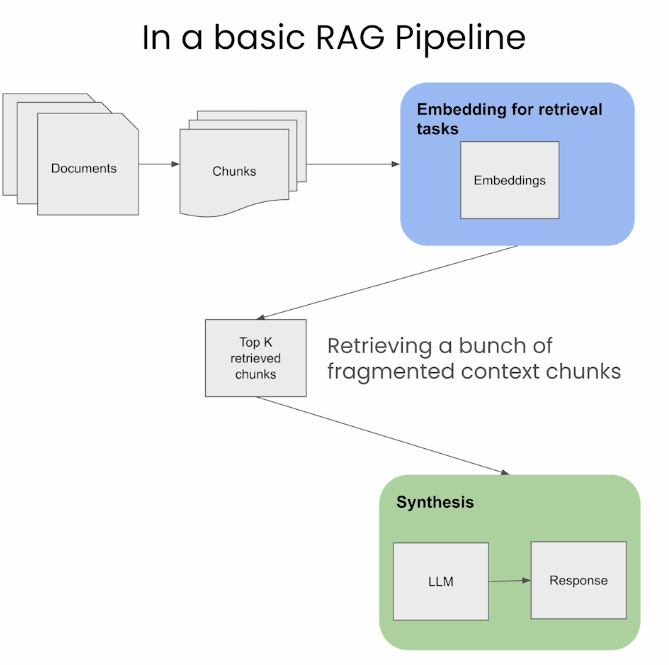

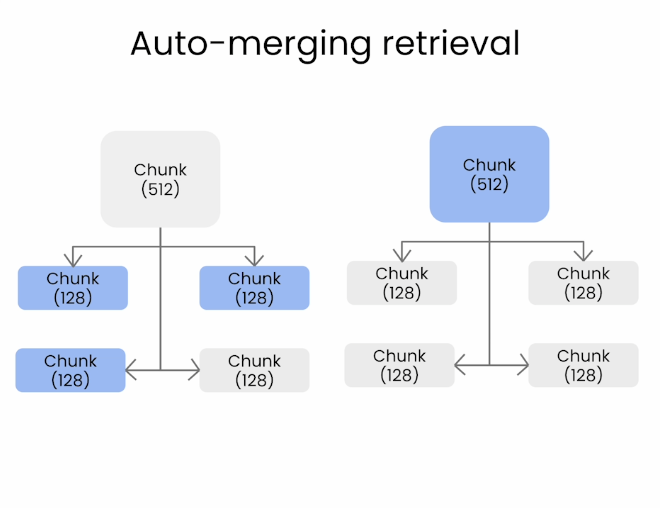

- Define a hierarchy of smaller chunks linked to parent chunks.
- If the set of smaller chunks linking to a parent chunk exceeds some threshold, then **merge** smaller chunks into the bigger parent chunk

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
from dotenv import load_dotenv

load_dotenv()

True

In [10]:
import utils

import os
import openai
openai.api_key = utils.get_openai_api_key()

In [11]:
from llama_index import SimpleDirectoryReader

documents = SimpleDirectoryReader(
    input_files = ['./data/eBook-How-to-Build-a-Career-in-AI_2.pdf']
).load_data()

In [12]:
print(type(documents), "\n")
print(len(documents), "\n")
print(type(documents[0]))
print(documents[0])

<class 'list'> 

41 

<class 'llama_index.schema.Document'>
Doc ID: 4eda583d-8b13-4b61-80ee-810691096f24
Text: PAGE 1Founder, DeepLearning.AICollected Insights from Andrew Ng
How to  Build Your Career in AIA Simple Guide


### Auto-merging retrieval setup

In [16]:
from llama_index import Document

document = Document(text = "\n\n".join(doc.text for doc in documents))

In [8]:
from llama_index.node_parser import HierarchicalNodeParser

# create toy nodes
node_parser = HierarchicalNodeParser.from_defaults(
    chunk_sizes = [2048, 512, 128]
)

In [9]:
# get the data from all nodes

nodes = node_parser.get_nodes_from_documents([document])

In [10]:
from llama_index.node_parser import get_leaf_nodes

leaf_nodes = get_leaf_nodes(nodes)

print(leaf_nodes[20].text)

I’ve found EDA particularly 
useful in data-centric AI development, where analyzing errors and gaining insights can really help 
drive progress! Finally, a basic intuitive understanding of calculus will also help. The math needed 
to do machine learning well has been changing. For instance, although some tasks require calculus, 
improved automatic differentiation software makes it possible to invent and implement new neural 
network architectures without doing any calculus. This was almost impossible a decade ago.Learning Technical Skills For a Promising AI Career CHAPTER 2

PAGE 10This is a lot to learn!


In [12]:
nodes_by_id = {node.node_id: node for node in nodes}

parent_node = nodes_by_id[leaf_nodes[20].parent_node.node_id]

print(parent_node.text)

I’ve found EDA particularly 
useful in data-centric AI development, where analyzing errors and gaining insights can really help 
drive progress! Finally, a basic intuitive understanding of calculus will also help. The math needed 
to do machine learning well has been changing. For instance, although some tasks require calculus, 
improved automatic differentiation software makes it possible to invent and implement new neural 
network architectures without doing any calculus. This was almost impossible a decade ago.Learning Technical Skills For a Promising AI Career CHAPTER 2

PAGE 10This is a lot to learn!
Even after you master everything on this list, I hope you’ll keep learning and continue to deepen 
your technical knowledge.


### Building the index

In [13]:
from llama_index.llms import OpenAI

llm = OpenAI(model = "gpt-3.5-turbo", temperature = 0.1)

In [14]:
from llama_index import ServiceContext

auto_merging_context  = ServiceContext.from_defaults(
    llm = llm,
    embed_model = "local:BAAI/bge-small-en-v1.5",
    node_parser = node_parser
)

In [15]:
import os
from llama_index import VectorStoreIndex, StorageContext, load_index_from_storage
from llama_index import load_index_from_storage

if not os.path.exists("./merging_index"):
    storage_context = StorageContext.from_defaults()
    storage_context.docstore.add_documents(nodes)

    automerging_index = VectorStoreIndex(
        leaf_nodes,
        storage_context = storage_context,
        service_context = auto_merging_context 
    )

    automerging_index.storage_context.persist(persist_dir = "./merging_index")
else:
    automerging_index = load_index_from_storage(
        StorageContext.from_defaults(persist_dir = "./merging_index"),
        service_context = auto_merging_context
    )

### Defining the retriever and running the query engine

In [16]:
from llama_index.indices.postprocessor import SentenceTransformerRerank
from llama_index.retrievers import AutoMergingRetriever
from llama_index.query_engine import RetrieverQueryEngine

automerging_retriever = automerging_index.as_retriever(
    similarity_top_k = 12
)

retriever = AutoMergingRetriever(
    automerging_retriever,
    automerging_index.storage_context,
    verbose = True
)

rerank = SentenceTransformerRerank(top_n = 6, model = "BAAI/bge-reranker-base")

auto_merging_engine = RetrieverQueryEngine.from_args(
    automerging_retriever, node_postprocessors=[rerank]
)

In [17]:
auto_merging_response = auto_merging_engine.query(
    "What is the importance of networking in AI?"
)

In [18]:
from llama_index.response.notebook_utils import display_response

display_response(auto_merging_response)

**`Final Response:`** Networking is important in AI because it allows individuals to build a strong professional network and community. This network can provide valuable information, help with career advancement, and offer support and advice when needed. By connecting with others in the AI community, individuals can also increase their visibility and recognition for their expertise. Additionally, networking can lead to referrals for potential job opportunities. Building a community and fostering relationships within the AI field can be more beneficial than simply focusing on personal networking efforts.

# Putting it all Together

In [17]:
import os

from llama_index import (
    ServiceContext,
    StorageContext,
    VectorStoreIndex,
    load_index_from_storage,
)

from llama_index.node_parser import HierarchicalNodeParser
from llama_index.node_parser import get_leaf_nodes
from llama_index import StorageContext, load_index_from_storage
from llama_index.retrievers import AutoMergingRetriever
from llama_index.indices.postprocessor import SentenceTransformerRerank
from llama_index.query_engine import RetrieverQueryEngine

def build_automerging_index(
        documents,
        llm,
        embed_model = "local:BAAI/bge-small-en-v1.5",
        save_dir = "merging_index",
        chunk_sizes = None,
):
    # chunk size is 4X as each level changing
    chunk_sizes = chunk_sizes or [2048, 512, 128]
    node_parser = HierarchicalNodeParser.from_defaults(chunk_sizes = chunk_sizes)
    nodes = node_parser.get_nodes_from_documents(documents)
    leaf_nodes = get_leaf_nodes(nodes)
    merging_context = ServiceContext.from_defaults(
        llm = llm,
        embed_model = embed_model,
    )
    storage_context = StorageContext.from_defaults()
    storage_context.docstore.add_documents(nodes)

    if not os.path.exists(save_dir):
        automerging_index = VectorStoreIndex(
            leaf_nodes, storage_context = storage_context, service_context = merging_context
        )
        automerging_index.storage_context.persist(persist_dir = save_dir)
    else:
        automerging_index = load_index_from_storage(
            StorageContext.from_defaults(persist_dir = save_dir),
            service_context = merging_context,
        )
    return automerging_index

def get_automerging_query_engine(
        automerging_index,
        similarity_top_k = 12,
        rerank_top_n = 6,
):
    base_retriever = automerging_index.as_retriever(similarity_top_k = similarity_top_k)
    retriever = AutoMergingRetriever(
        base_retriever, automerging_index.storage_context, verbose = True
    )

    rerank = SentenceTransformerRerank(
        top_n = rerank_top_n, model = "BAAI/bge-reranker-base"
    )

    auto_merging_engine = RetrieverQueryEngine.from_args(
        retriever, node_postprocessors = [rerank]
    )
    return auto_merging_engine


In [18]:
from llama_index.llms import OpenAI

index = build_automerging_index(
    [document],
    llm = OpenAI(model = "gpt-3.5-turbo", temperature = 0.1),
    save_dir = "./merging_index",
)

In [19]:
query_engine = get_automerging_query_engine(index, similarity_top_k = 6)

## TruLens Evaluation

In [20]:
from trulens_eval import Tru

Tru().reset_database()

🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `Tru` to prevent this.


#### Two layers

In [21]:
auto_merging_index_0 = build_automerging_index(
    documents,
    llm = OpenAI(model = "gpt-3.5-turbo", temperature = 0.1),
    embed_model = "local:BAAI/bge-small-en-v1.5",
    save_dir = "merging_index_0",
    chunk_sizes = [2048, 512],
)

In [22]:
auto_merging_engine_0 = get_automerging_query_engine(
    auto_merging_index_0,
    similarity_top_k = 12,
    rerank_top_n = 6,
)

In [23]:
from utils import get_prebuilt_trulens_recorder

tru_recorder = get_prebuilt_trulens_recorder(
    auto_merging_engine_0,
    app_id = "app_0_two_layers"
)

In [24]:
eval_questions = []
with open('./data/generated_questions.text', 'r') as file:
    for line in file:
        item = line.strip()
        eval_questions.append(item)

In [25]:
def run_evals(eval_questions, tru_recorder, query_engine):
    for question in eval_questions:
        with tru_recorder as recording:
            response = query_engine.query(question)

In [26]:
run_evals(eval_questions, tru_recorder, auto_merging_engine_0)

> Merging 2 nodes into parent node.
> Parent node id: 825a54cf-d51d-4737-afbd-d0c47b925d68.
> Parent node text: PAGE 20Working on projects requires making tough choices about what to build and how to go 
about...

> Merging 1 nodes into parent node.
> Parent node id: 018a9ef1-a745-4435-9f64-eb71628d0b53.
> Parent node text: PAGE 7These phases apply in a wide 
range of professions, but AI 
involves unique elements.
For e...

> Merging 1 nodes into parent node.
> Parent node id: 0f06de76-3969-4528-9546-3698558b406a.
> Parent node text: PAGE 18It goes without saying that we should only work on projects that are responsible, ethical,...

> Merging 1 nodes into parent node.
> Parent node id: 1c738056-45d6-4e11-a55d-ac47475d0062.
> Parent node text: PAGE 22Over the course of a career, you’re likely to work on projects in succession, each growing...

> Merging 1 nodes into parent node.
> Parent node id: 82b6411c-5a9d-4177-9ec9-d3c7f2a73625.
> Parent node text: PAGE 15One of the most important

In [28]:
from trulens_eval import Tru

Tru().get_leaderboard(app_ids=[])

,Context Relevance,Groundedness,Answer Relevance,latency,total_cost
app_id,,,,,
app_0_two_layers,0.166667,0.888889,1.0,11.0,0.004673


### Three layers

In [33]:
Tru().reset_database()

In [34]:
auto_merging_index_1 = build_automerging_index(
    documents,
    llm = OpenAI(model = "gpt-3.5-turbo", temperature = 0.1),
    embed_model = "local:BAAI/bge-small-en-v1.5",
    save_dir = "merging_index_1",
    chunk_sizes = [2048, 512, 128]
)

In [35]:
auto_merging_engine_1 = get_automerging_query_engine(
    auto_merging_index_1,
    similarity_top_k = 12,
    rerank_top_n = 6,
)

In [36]:
tru_recorder = get_prebuilt_trulens_recorder(
    auto_merging_engine_1,
    app_id="app_1_three_layers",
)

In [37]:
run_evals(eval_questions, tru_recorder, auto_merging_engine_1)

> Merging 4 nodes into parent node.
> Parent node id: 6561e924-299b-4b4d-a29c-58f18cbaa1eb.
> Parent node text: PAGE 20Working on projects requires making tough choices about what to build and how to go 
about...

> Merging 2 nodes into parent node.
> Parent node id: 5be2870d-fbdd-48c2-b1dc-7adb1264e0af.
> Parent node text: But when committing to a direction means making a costly investment or entering a one-
way door  ...

> Merging 2 nodes into parent node.
> Parent node id: beb3f1bf-11d9-4114-b337-5b23a2f7f15f.
> Parent node text: PAGE 20Working on projects requires making tough choices about what to build and how to go 
about...



In [39]:
from trulens_eval import Tru

Tru().get_leaderboard(app_ids=[])

,Context Relevance,Answer Relevance,latency,total_cost
app_id,,,,
app_1_three_layers,0.166667,1.0,8.0,0.002287
